In [1]:
library(IBMPopSim)
library(ggplot2)


Attachement du package : ‘IBMPopSim’


L'objet suivant est masqué depuis ‘package:stats’:

    stepfun




In [2]:
#update.packages(checkBuilt=TRUE, ask=FALSE)
#install.packages("Rcpp")
#install.packages("IBMPopSim")
#install.packages("devtools")
#install.packages("IRkernel")
#IRkernel::installspec()

In [149]:
pop_init <- data.frame("birth"=rep(0,100), "death"=rep(NA,100), "smurfness"=rep(0,100))
params <- list("a" = 0.075,
               "t0" = 10.0,
               "k_int" = 0.19,
               "compet" = 0.000001, 
               "birth_rate" = 0.2)


In [150]:
death_event <- mk_event_individual(name = "death1", type = "death",
    intensity_code = 'if (I.smurfness==0)
            result = 0;
        else
            result = k_int;'
)

In [151]:
death_event2 <- mk_event_interaction(name = "death2", type = "death", 
    interaction_code = 'result = compet;'
)                                     

In [152]:
birth_event <- mk_event_individual(type="birth",
    intensity_code = 'if (I.smurfness==0)
            result = birth_rate;
        else
            result = birth_rate/15;',
    kernel_code = 'newI.smurfness=0;'
)

In [153]:
swap_event <- mk_event_individual(
    type = "swap",
    intensity_code = 'if (I.smurfness==0){
                            if (age(I,t)==0)
                                result = 0;
                            else
                                result = (a*age(I,t)*exp(-t0/age(I,t)));
                            }
                        else
                            result = 0;',
    kernel_code = 'I.smurfness=1;'
)

In [154]:
model <- mk_model(
    characteristics = get_characteristics(pop_init),
    events = list(death_event, death_event2, swap_event, birth_event),
    parameters = params,
    with_id = TRUE) #adds individuals IDs

summary(model)

[1] "add 'id' as individual attributes"
Events:
#1: individual event of type death
#2: interaction event of type death
#3: individual event of type swap
#4: individual event of type birth
--------------------------------------- 
Individual description:
names:  birth death smurfness id 
R types:  double double double integer 
C types:  double double double int
--------------------------------------- 
R parameters available in C++ code:
names:  a t0 k_int compet birth_rate 
R types:  double double double double double 
C types:  double double double double double

In [155]:
death_max <- params$k_int
swap_max <- params$a*50*exp(-params$t0/50)

In [156]:
T = 0:50 # Simulation end time 


sim_out <- popsim(model = model, age_max = 50,
  population = pop_init,
  events_bounds = c('death1'=death_max,'death2'=params$compet, 'swap'= swap_max, 'birth'= params$birth_rate),
  parameters = params,
  time = T)

[1] "Add 'id' attributes to the population."
Simulation on  [0, 1]  [1, 2]  [2, 3]  [3, 4]  [4, 5]  [5, 6]  [6, 7]  [7, 8]  [8, 9]  [9, 10]  [10, 11]  [11, 12]  [12, 13]  [13, 14]  [14, 15]  [15, 16]  [16, 17]  [17, 18]  [18, 19]  [19, 20]  [20, 21]  [21, 22]  [22, 23]  [23, 24]  [24, 25]  [25, 26]  [26, 27]  [27, 28]  [28, 29]  [29, 30]  [30, 31]  [31, 32]  [32, 33]  [33, 34]  [34, 35]  [35, 36]  [36, 37]  [37, 38]  [38, 39]  [39, 40]  [40, 41]  [41, 42]  [42, 43]  [43, 44]  [44, 45]  [45, 46]  [46, 47]  [47, 48]  [48, 49]  [49, 50] 

In [157]:
#mortality per age general pop
pop_final <- sim_out$population[[50]]
#Dx <- death_table(pop_final, 0:100, 0:100)
#Ex <- exposure_table(pop_final, 0:100, 0:100)
all_dead <- pop_final[is.na(pop_final$death)==FALSE,]
dim(all_dead[all_dead$smurfness==1,])[1]/dim(all_dead)[1]

[1] 0.3901752

In [158]:
dim(pop_final)[1]
dim(all_dead)[1]

[1] 195782

[1] 94842

In [159]:
prop_dead <-  function(i){pop= sim_out$population[[i]];
                                all_dead <- pop[is.na(pop$death)==FALSE,]
return(dim(all_dead)[1]/dim(pop)[1]) }

In [160]:
taux_smurf_dead<- function(i){pop= sim_out$population[[i]];
                                all_dead <- pop[is.na(pop$death)==FALSE,]
return(dim(all_dead[all_dead$smurfness==1,])[1]/dim(all_dead)[1]) }

In [161]:
vec_taux_smurf_dead<- sapply(1:50,function(i)(taux_smurf_dead(i)))
vec_prop_dead<- sapply(1:50,function(i)(prop_dead(i)))

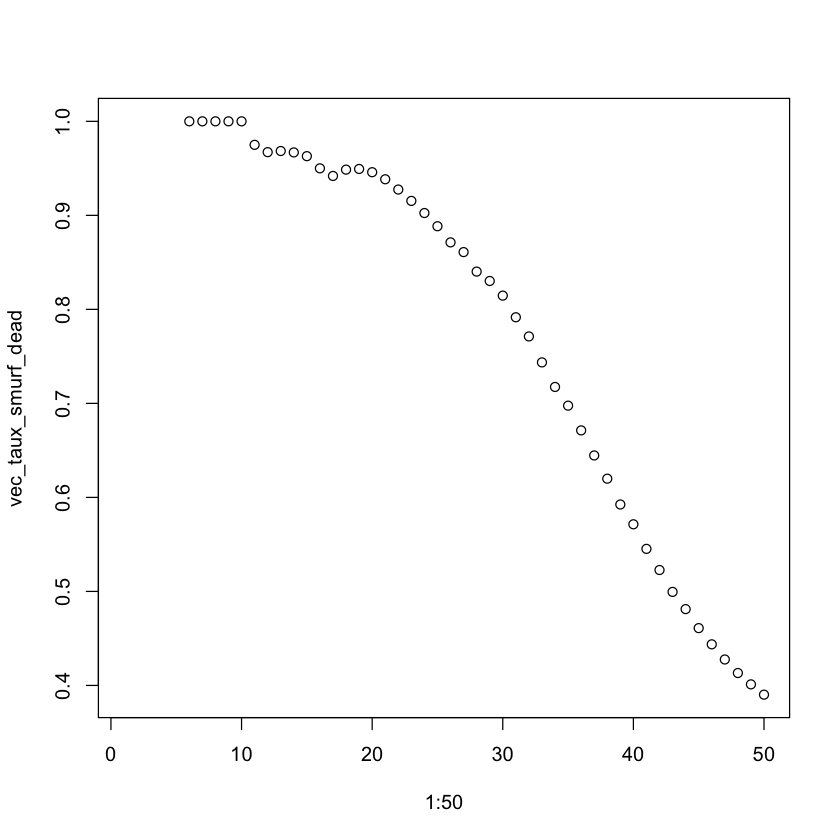

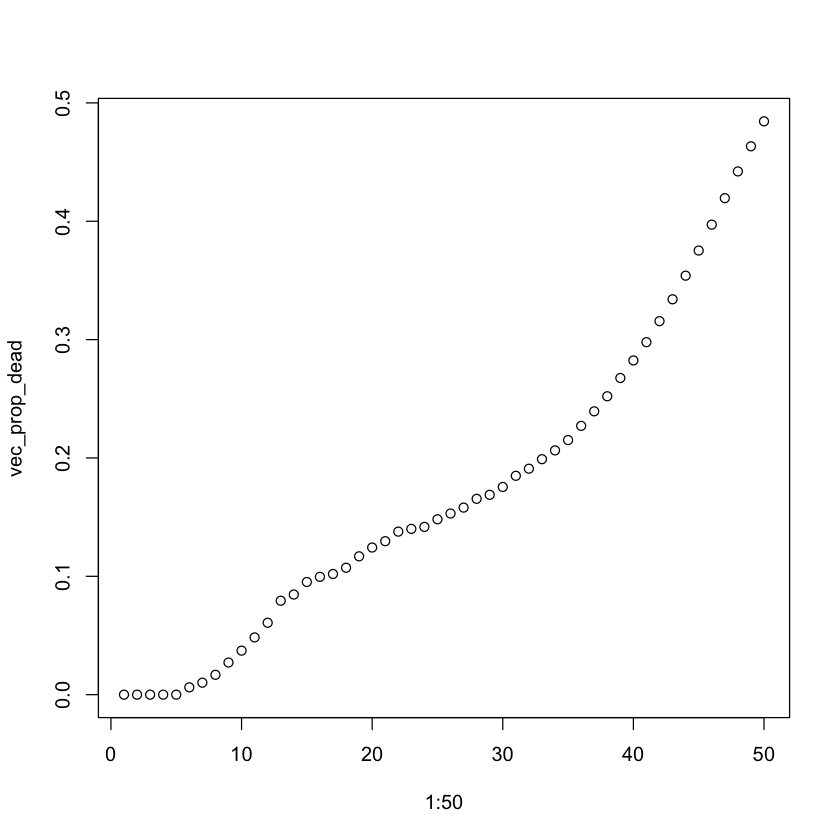

In [162]:
plot(1:50,vec_taux_smurf_dead)
plot(1:50,vec_prop_dead)

In [163]:
taux_smurf_alive<- function(i){pop= sim_out$population[[i]];
                                alive <- pop[is.na(pop$death),]
return(dim(alive[alive$smurfness==1,])[1]/dim(alive)[1]) }
nalive <- function(i){pop= sim_out$population[[i]];
                                alive <- pop[is.na(pop$death),]
return(dim(alive)[1]) }

In [164]:
vec_taux_smurf_alive<- sapply(1:50,function(i)(taux_smurf_alive(i)))
N_alive<- sapply(1:50,function(i)(nalive(i)))

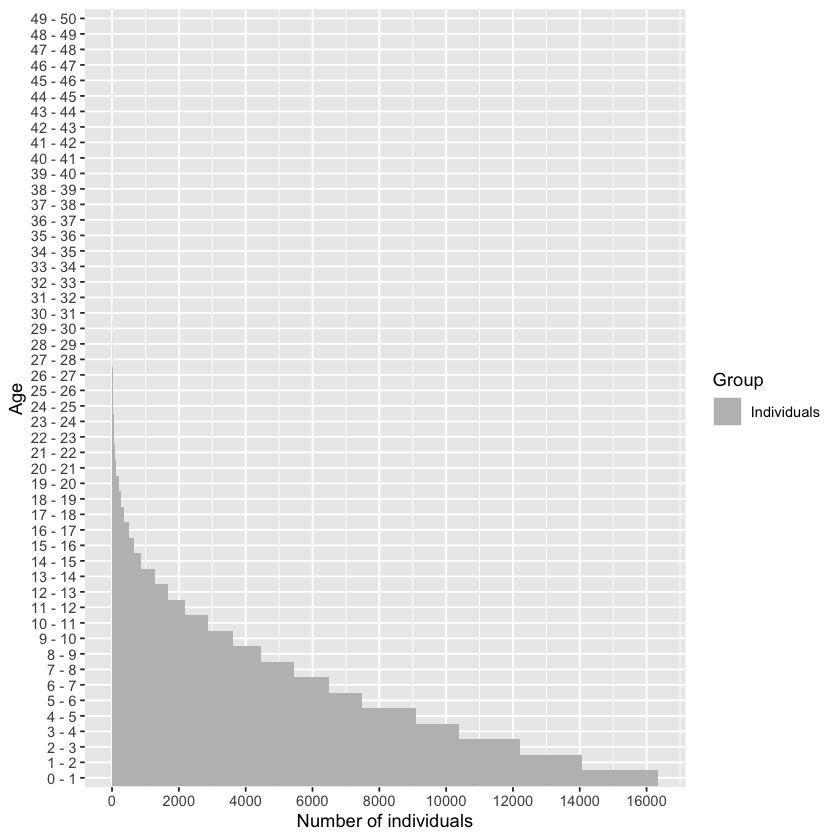

In [165]:
#pyr_init = age_pyramid(sim_out$population[[100]], time = 100,ages = 0:50)
pyr = age_pyramid(sim_out$population[[50]], time = 50, ages=0:50)
#plot_pyramid(pyr_init,age_breaks = 0:50)
plot_pyramid(pyr,age_breaks = 0:50)

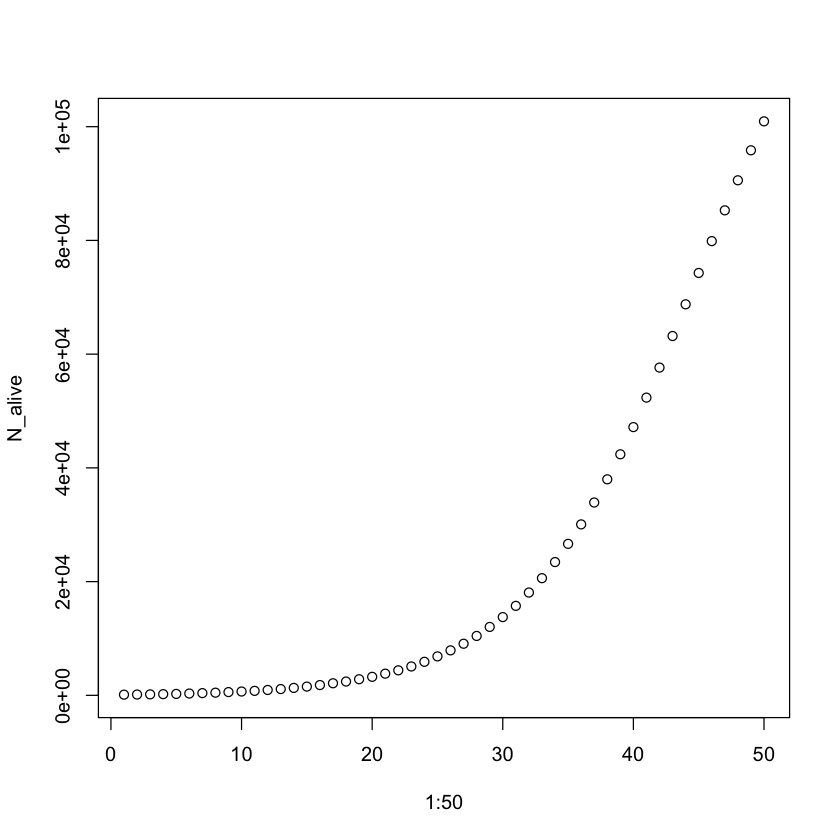

In [168]:
plot(1:50,N_alive)

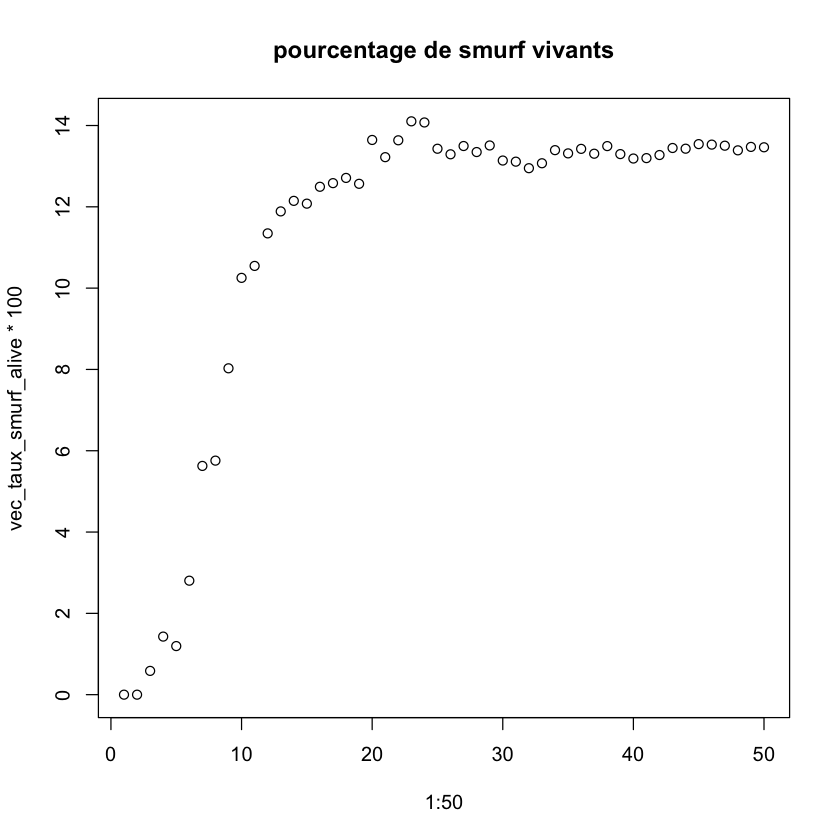

In [169]:
plot(1:50,vec_taux_smurf_alive*100, main="pourcentage de smurf vivants")

## Analyse d'une cohorte

In [170]:
pop_final <- sim_out$population[[50]]
nb_alive_NS<- c()
nb_alive_S<- c()
for (i in 1:50){
    pop<-sim_out$population[[i]]
nb_alive_NS<-c(nb_alive_NS,  dim(pop[pop$birth>=0& pop$birth<1& is.na(pop$death) & pop$smurfness==0 ,])[1])
nb_alive_S<-c(nb_alive_S,  dim(pop[pop$birth>=0& pop$birth<1& is.na(pop$death) & pop$smurfness==1 ,])[1])  
}

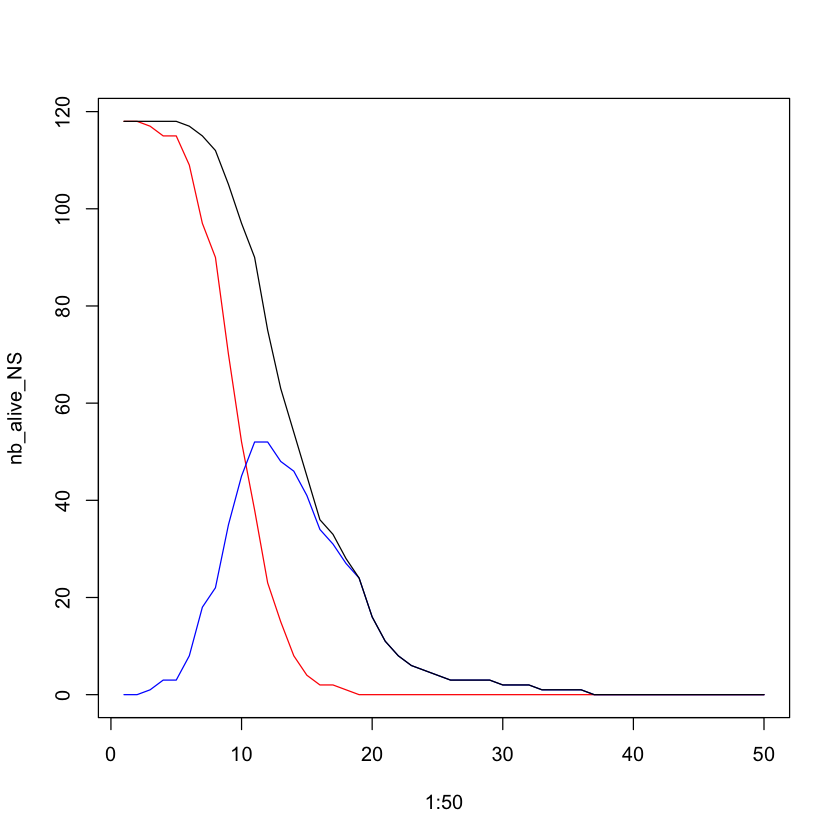

In [171]:
plot(1:50,nb_alive_NS, type='l',col="red")
lines(1:50,nb_alive_S, col="blue")
lines(1:50,nb_alive_NS+nb_alive_S)

In [22]:

survival <- sapply(1:100, function(i) (Ex[i,i]))

ERROR: Error in FUN(X[[i]], ...): objet 'Ex' introuvable


In [ ]:
plot(0:99, survival)